##### **Sharpe ratio computation**

In [ ]:
# Get necessary data
aapl = pd.read_csv("apple.csv", index_col="Date",parse_dates=True)
msft = pd.read_csv("msft.csv", index_col="Date",parse_dates=True)

aapl["Daily Return"] = aapl["Adj Close"].pct_change(1)
msft["Daily Return"] = msft["Adj Close"].pct_change(1)

aapl = aapl.dropna()
msft = msft.dropna()

In [ ]:
def compute_sharpe_ratio(data, risk_free_rate = 0.045/252): #default rf to be 4.5% annually
    mean_return = data["Daily Return"].mean()
    std = data["Daily Return"].std()
    sharpe_ratio = (mean_return-risk_free_rate) / std
    #DAILY SHARPE RATIO (because it's using daily return)
    return sharpe_ratio

# apply the function to find daily sharpe ratio
sr_apple = compute_sharpe_ratio(aapl)
sr_microsoft = compute_sharpe_ratio(msft)

# annualize the result
annual_sr_apple = (252**0.5) * sr_apple
annual_sr_microsoft = (252**0.5) * sr_microsoft

##### **Sortino ratio computation**

In [ ]:
def compute_sortino_ratio(data, target, risk_free_rate=0.045/252):
    mean_return = data["Daily Return"].mean()
    downside = data[data["Daily Return"] < target]["Daily Return"]
    std = downside.std()
    sortino_ratio = (mean_return-risk_free_rate) / std
    return sortino_ratio

# apply the function
sr_apple = compute_sortino_ratio(aapl, target=0)
sr_microsoft = compute_sortino_ratio(msft, target=0)

# annualize the result
annual_sr_apple = (252**0.5) * sr_apple
annual_sr_microsoft = (252**0.5) * sr_microsoft

##### **Probabilistic Sharpe Ratio (PSR) computation**

The probabilistic sharpe ratio computes the propability that the true sharpe ratio is $\leq$ the estimated sharpe ratio ($PSR = P(SR \leq \widehat{\text{SR}})$) given the benchmark sharpe ratio.

In [ ]:
import scipy.stats
def compute_prob_sharpe_ratio(data, benchmark=0):
    sr = compute_sharpe_ratio(data, 0.045/252)
    skew = scipy.stats.skew(data["Daily Return"])
    # Use fisher kurtosis 
    kurtosis = scipy.stats.kurtosis(data["Daily Return"], fisher=True)  
    n = len(data)
    std = ( (1 / (n-1)) * (1 + 0.5 * sr**2 - skew * sr + (kurtosis / 4) * sr**2))**0.5
    ratio = (sr - benchmark) / std
    prob_sharpe_ratio = scipy.stats.norm.cdf(ratio)
    return prob_sharpe_ratio

# apply the function to find daily PSR
psr_apple = compute_prob_sharpe_ratio(aapl)
psr_microsoft = compute_prob_sharpe_ratio(msft)

# annualize the result
annual_psr_apple = (252**0.5) * psr_apple
annual_psr_microsoft = (252**0.5) * psr_microsoft

##### **Return Calculation**

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

retail = yf.download(['COST','TGT','WMT','DG'],period='10y')['Adj Close']

[*********************100%***********************]  4 of 4 completed


In [54]:
# Calculate returns
retail_returns = retail.pct_change(1).dropna()

In [ ]:
# Plot return distrbution
retail_returns['COST'].plot(kind='hist',bins=100,figsize=(12,3))

In [63]:
# Calculate cumulative return
cum_return_cost = (1 + retail_returns['COST']).cumprod() - 1
cum_return_tgt = (1 + retail_returns['TGT']).cumprod() - 1
cum_return_wmt = (1 + retail_returns['WMT']).cumprod() - 1
cum_return_dg = (1 + retail_returns['DG']).cumprod() - 1

Text(0, 0.5, 'Cumulative Return %')

<Figure size 960x720 with 0 Axes>

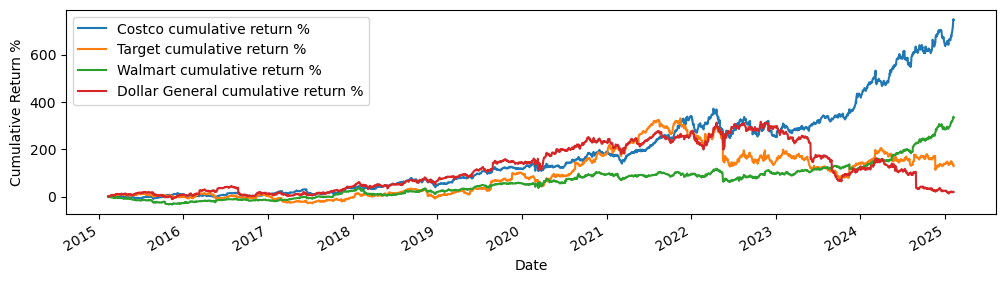

In [93]:
# Add to dataframe and plot cumulative returns
cum_returns_df = pd.DataFrame({'Costco cumulative return %':cum_return_cost*100,
                               'Target cumulative return %':cum_return_tgt*100,
                               'Walmart cumulative return %':cum_return_wmt*100,
                               'Dollar General cumulative return %':cum_return_dg*100
                              })
plt.figure(dpi=150)
cum_returns_df.plot(figsize=(12,3))
plt.ylabel("Cumulative Return %")

In [ ]:
# Weighted Return (25/15/35/25)
sample_wgt_ret = np.dot([.25,.15,.35,.25],retail_returns.transpose())

# Cumulative Return
sample_cum_return = pd.Series(100*((1+sample_wgt_ret).cumprod() - 1),index=retail_returns.index)

sample_cum_return.plot(ylabel='Return in %',title='Cumulative Return of 25/15/35/25 Portfolio',figsize=(10,2))
plt.show()

In [ ]:
# Equal weighted
N = len(retail_returns.columns)
equal_wgt= N * [1/N] # Shows 1/4, 4 times. Its not multiplication, but repetition! 4*["A"]

equal_wgt_ret = np.dot(equal_wgt,retail_returns.transpose())

equal_cum_return = pd.Series(100*((1+equal_wgt_ret).cumprod() - 1),index=retail_returns.index)
equal_cum_return.plot(ylabel='Return in %',title='Cumulative Return of Equal Weighted Portfolio',figsize=(10,2))
plt.show()

In [ ]:
# Plot on same graph for comparison
equal_cum_return.plot(figsize=(10,2),label='Equal Weight')
sample_cum_return.plot(figsize=(10,2),label='Sample Weight')
plt.legend()

##### **Monte Carlo Simulation to Find Optimized Weights**

In [170]:
# Get log returns
log_returns = np.log(retail/retail.shift(1))

# Get Return Covariance Matrix
log_returns_cov = log_returns.cov()

# Function to generate random weights
def gen_weights(N):
    weights = np.random.random(N)
    return weights/ np.sum(weights) # Make sure all weights add up to 1

# Function to calculate return for each weight combination
def calculate_returns(weights,log_returns):
    return np.sum(log_returns.mean()*weights) * 252 #Annualized Returns

# Function to calculate volatility for each weight combination
def calculate_volatility(weights,log_returns_cov):
    annualized_cov = np.dot(log_returns_cov*252,weights)
    vol = np.dot(weights.transpose(),annualized_cov)
    return np.sqrt(vol)

In [172]:
mc_portfolio_returns = []
mc_portfolio_vol = []
mc_weights = []
for sim in range(6000):
    # This may take awhile!
    weights = gen_weights(N=4)
    mc_weights.append(weights)
    mc_portfolio_returns.append(calculate_returns(weights,log_returns))
    mc_portfolio_vol.append(calculate_volatility(weights,log_returns_cov))

# Calculate sharpe ratios for each weight combination generated once simulation is complete
mc_sharpe_ratios = np.array(mc_portfolio_returns)/np.array(mc_portfolio_vol)

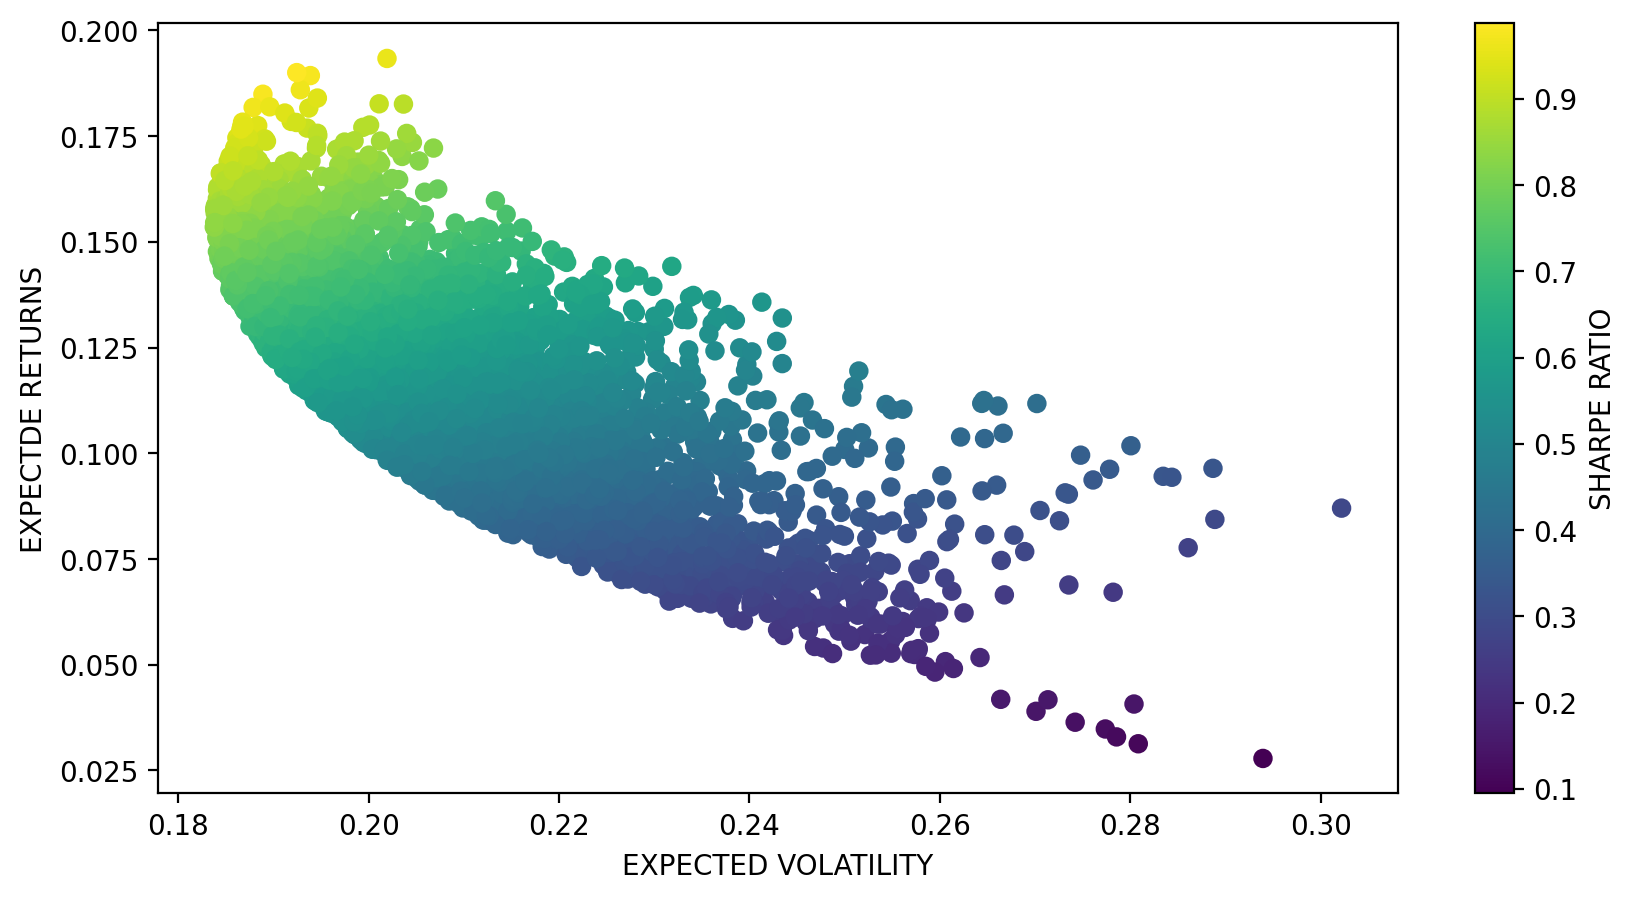

In [174]:
plt.figure(dpi=200,figsize=(10,5))
plt.scatter(mc_portfolio_vol,mc_portfolio_returns,c=mc_sharpe_ratios)
plt.ylabel('EXPECTDE RETURNS')
plt.xlabel('EXPECTED VOLATILITY')
plt.colorbar(label="SHARPE RATIO");

In [176]:
# Optimized portfolio with highest Sharpe ratio from the MC result
mc_weights[np.argmax(mc_sharpe_ratios)]

array([0.69148577, 0.01755968, 0.01943697, 0.27151758])

##### **Optimization with Scipy.Optimize Library**

In [178]:
from scipy.optimize import minimize
# help(minimize)

In [180]:
def function_to_minimize(weights):
    # Note -1* because we need to minimize the result. Equivalent to maximizing SR.
    return -1 * (calculate_returns(weights,log_returns)/calculate_volatility(weights,log_returns_cov))

In [182]:
bounds = tuple((0,1) for n in range(N))

# Set starting point of guessing
equal_wgt = N * [1/N]
sum_constraint = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1}) #Set constraint that all weights have to add up to 1
minimize(fun=function_to_minimize,x0=equal_wgt,bounds=bounds,constraints=sum_constraint)


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.0089260800535556
       x: [ 7.973e-01  0.000e+00  7.936e-17  2.027e-01]
     nit: 5
     jac: [-5.713e-05  5.366e-01  3.688e-01  2.248e-04]
    nfev: 25
    njev: 5

##### **Plotting Efficient Frontier**

In [188]:
expected_returns_range = np.linspace(np.min(mc_portfolio_returns),np.max(mc_portfolio_returns),100)
constraints = ({'type':'eq','fun': lambda weights: np.sum(weights)-1},
               {'type':'eq','fun': lambda weights: calculate_returns(weights,log_returns) - possible_return})

# Define volatility calculation again for the optimization
def calculate_volatility(weights):
    annualized_cov = np.dot(log_returns_cov*252,weights)
    vol = np.dot(weights.transpose(),annualized_cov)
    return np.sqrt(vol)
    
# loop through different returns
frontier_volatility = []
portfolio_holdings = []

for possible_return in expected_returns_range:
    # function for return
    result = minimize(calculate_volatility,equal_wgt,bounds=bounds,constraints=constraints)
    frontier_volatility.append(result['fun'])
    portfolio_holdings.append(result['x'])

C:\Users\chung\AppData\Local\Temp\ipykernel_39436\2934716548.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(frontier_volatility,expected_returns_range,'r--',linewidth=2,color='red')


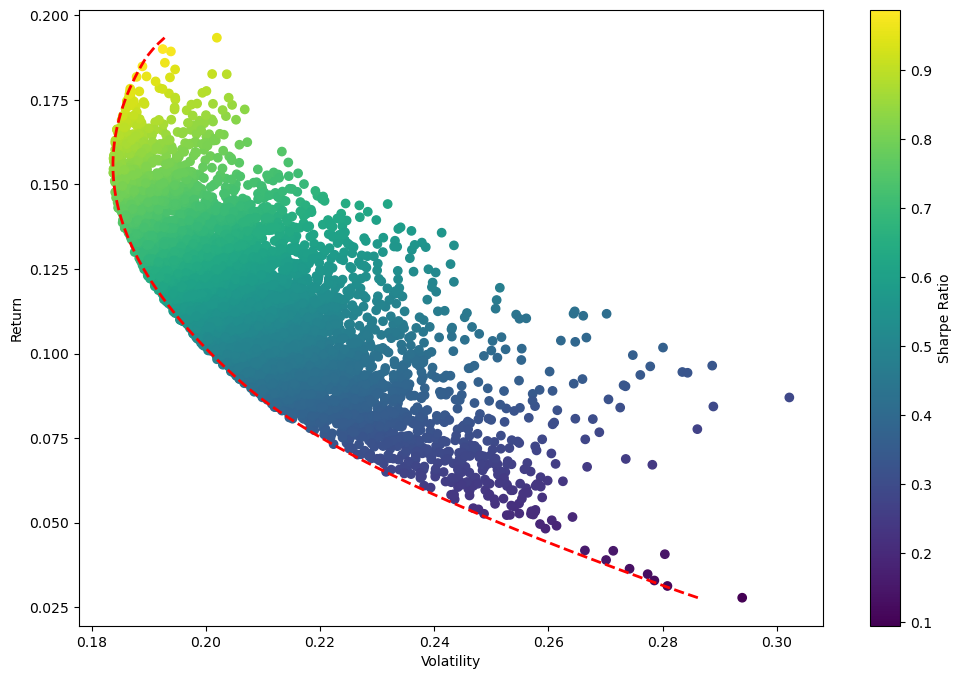

In [202]:
# Plotting the frontier
plt.figure(figsize=(12,8))
plt.scatter(mc_portfolio_vol,mc_portfolio_returns,c=mc_sharpe_ratios)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
# Add frontier line
plt.plot(frontier_volatility,expected_returns_range,'r--',linewidth=2,color='red')

In [212]:
#If we decide that we can take a little more volatility instead of one with maximized sharpe ratio, we can search for it
frontier_volatility = np.array(frontier_volatility)
np.where(frontier_volatility > 0.26)
print('Portfolio weights:',portfolio_holdings[5]) #for example
print('Expected return:',expected_returns_range[5])
print('Volatility:',frontier_volatility[5])

Portfolio weights: [2.98155597e-17 7.77611770e-01 1.70213412e-01 5.21748178e-02]
Expected return: 0.036176240080956615
Volatility: 0.27235110306219806
